<a href="https://colab.research.google.com/github/PasechnikDarya/RAAI-NLP-Project/blob/main/topic_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузка данных

In [1]:
import torch
import itertools
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.4)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [84]:
data = pd.read_csv('/content/drive/MyDrive/blogtext.csv')

In [85]:
data.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [86]:
data['text'][456]

"              Frustration  I'm so frustrated! At the lack of productivity. At the hunger pangs caused by waiting...waiting...waiting...  I'm meant BE at Soony and Michy's for dinner right now, yet am stuck waiting for my ride to come, who's in turn, stuck at a meeting which should have been settled eons ago. The complications of starting a new business. Sheesh...  Ah wells. Yuli is heading down now to hand me some forms for data entry. Yippee. Am finally  doing  something...           "

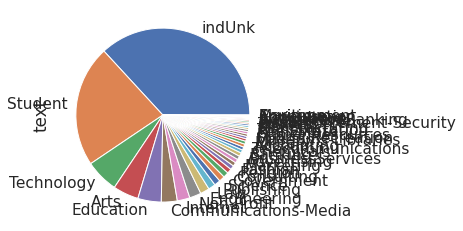

In [87]:
data.groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].plot.pie()

Оставили только 5 классов, аргументы приведены ниже в блоке "анализ данных". Так же исключили неразмеченные топики. Соображения такие: каждый блог имеет ровно один топик и каждый автор пришет статьи строго под одним топик. Среди неразмеченных топиков (их больше 35%) получилось найти очень разные тексты, которые человек бы мог отнести к одному из 40  классов. Поэтому оставлять их с меткой "indUnk" нелогично - они будут сбивать сеть с выявления признаков текста, характерных обозначеннным темам.

In [88]:
NUM_CLASSES = 5

data = data[data['topic'] != 'indUnk']
classes = data.groupby('topic', as_index=False).count()[['text', 'topic']].sort_values(['text'], ascending=False)['topic'].values[:NUM_CLASSES]

data = data[data['topic'].isin(classes)].reset_index(drop=True)

In [89]:
frequencies = data.groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].values / data.shape[0]
frequencies

array([0.55324969, 0.15117909, 0.11664749, 0.10652455, 0.07239917])

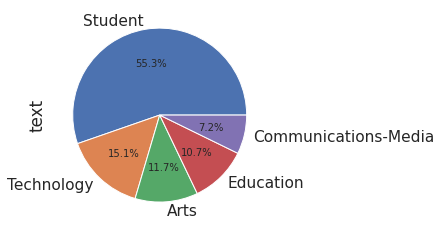

In [90]:
data.groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].plot.pie(autopct="%.1f%%")

Пробовали сделать выборку сбалансированной, но так как можель сложная, то очень быстро начинает переобучаться. Так что используем все данные. Вместо этого добавили регуляризацию - штрафуем за самый частый класс. Так же добавили дропаут, чтобы замедлить переобучение.

In [91]:
# for balanced data

# one_class_size = data[data['topic'] == classes[-1]].shape[0]

# prepr_data = pd.concat([data[data['topic'] == x][:one_class_size] for x in classes], axis=0)

# old_data = data
# data = prepr_data.reset_index(drop=True)

In [92]:
CUT = data.shape[0] #100000

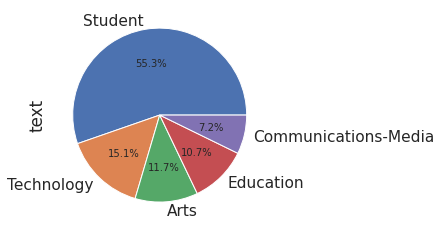

In [93]:
data.loc[:CUT, :].groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].plot.pie(autopct="%.1f%%")

In [94]:
label2idx = {label: i for i, label in enumerate(data['topic'].unique())}
idx2label = {i: label for i, label in enumerate(data['topic'].unique())}

In [95]:
for i in idx2label.keys():
  if label2idx[idx2label[i]] != i:
    print('aaa')

In [96]:
from sklearn.model_selection import train_test_split

train_indexes, test_indexes = train_test_split(data.index[:CUT], test_size=0.2, stratify=data['topic'][:CUT], shuffle=True)

In [97]:
class Dataset:

    def __init__(self, data, labels, vocab=None):
        self.vocab = vocab
        self.data = data
        self.tokenised = None
        self.labels = [label2idx[label] for label in labels]

    def __getitem__(self, index):
        answer = {"input": self.tokenised[index]}
        if self.labels is not None:
            answer["label"] = self.labels[index]
        return answer

    def __len__(self):
        return len(self.data)
    
    def cut_to_fixed_size(self, max_size=512):
        self.tokenised = [text[:max_size] for text in tqdm(self.tokenised)]

    def drop_too_short(self, min_size=1):
      self.labels = [label for idx, label in tqdm(enumerate(self.labels)) if len(self.tokenised[idx]) > min_size]
      self.data = [text for idx, text in tqdm(enumerate(self.data)) if len(self.tokenised[idx]) > min_size]
      self.tokenised = [text for text in tqdm(self.tokenised) if len(text) > min_size]


In [98]:
train_dataset = Dataset(list(data['text'].values[train_indexes]), list(data['topic'].values[train_indexes]))
test_dataset = Dataset(list(data['text'].values[test_indexes]), list(data['topic'].values[test_indexes]))

In [99]:
import nltk

nltk.download('stopwords')
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords as nltk_stopwords

nltk_stopwords = nltk_stopwords.words("english")

def is_word(word):
    word = word.lower()
    return all(x.isalpha() or x.isdigit() or x == "-" for x in word) and any(x.isalpha() or x.isdigit() for x in word)

def process_text(text, to_lower=True, only_alpha=True, remove_stopwords=False):
    words = wordpunct_tokenize(text) if isinstance(text, str) else text
    if to_lower:
        words = [word.lower() for word in words]
    if only_alpha:
        words = [word for word in words if is_word(word)]
    if remove_stopwords:
        words = [word for word in words if word not in nltk_stopwords]
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [100]:
train_dataset.tokenised = [process_text(text, remove_stopwords=True) for text in tqdm(train_dataset.data)]
test_dataset.tokenised = [process_text(text, remove_stopwords=True) for text in tqdm(test_dataset.data)]

# Загрузка эмбендингов

In [ ]:
##### bert #######

In [17]:
!pip install transformers

     |████████████████████████████████| 2.5MB 31.4MB/s 
     |████████████████████████████████| 901kB 44.7MB/s 
     |████████████████████████████████| 3.3MB 52.8MB/s 


In [24]:
from transformers import BertModel
import transformers as ppb

In [25]:
bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
bert_embeddings = list(bert.children())[0]
bert_word_embeddings = list(bert_embeddings.children())[0]
bert_embeddings = bert_word_embeddings.weight.data.numpy()

In [27]:
bert_embeddings.shape

(30522, 768)

In [28]:
tokenizer = ppb.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [29]:
max_len = 1000
for idx, text in tqdm(enumerate(train_dataset.data)):
    if len(text) > max_len:
        train_dataset.data[idx] = text[:max_len]

for idx, text in tqdm(enumerate(test_dataset.data)):
    if len(text) > max_len:
        test_dataset.data[idx] = text[:max_len]

In [30]:
train_dataset.tokenised = [tokenizer.encode(x, add_special_tokens=True) for x in train_dataset.data]
test_dataset.tokenised = [tokenizer.encode(x, add_special_tokens=True) for x in test_dataset.data]

Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors


In [31]:
len(train_dataset.tokenised[0])

91

In [32]:
train_dataset.cut_to_fixed_size(256)
test_dataset.cut_to_fixed_size(256)

In [33]:
train_dataset.drop_too_short()
test_dataset.drop_too_short()

In [ ]:
######### bert #########

In [ ]:
##### fasttext - fasttext-wiki-news-subwords-300 ##### glove - glove-twitter-50 ######

In [101]:
class Vocabulary:

    def __init__(self, vocab=None):
        self.vocab = vocab

    def encode(self, data):
        if isinstance(data, list) and len(data) > 0 and not isinstance(data[0], str):
            return [self.encode(text) for text in data]
        # data --- это отдельный текст
        indexes = [self.vocab.get(token, self.vocab['unk']) for token in data]
        return indexes

In [110]:
import gensim.downloader as api
glove_model = api.load("glove-twitter-200")

[==================================================] 100.0% 758.5/758.5MB downloaded


In [111]:
glove_word2idx = {word: idx for idx, word in enumerate(glove_model.index2word)}

glove_vocab = Vocabulary()
glove_vocab.vocab = glove_word2idx
# dataset.vocab = glove_vocab

In [112]:
train_dataset.tokenised = glove_vocab.encode(train_dataset.tokenised)
test_dataset.tokenised = glove_vocab.encode(test_dataset.tokenised)

In [113]:
train_dataset.cut_to_fixed_size(256)
test_dataset.cut_to_fixed_size(256)

In [114]:
train_dataset.drop_too_short()
test_dataset.drop_too_short()

In [115]:
len(test_dataset.labels), len(test_dataset.tokenised)

(54968, 54968)

## Анализ текстов

Сначала посмотрели на распределение длин текстов

In [ ]:
df = pd.DataFrame({'topic': [idx2label[x] for x in train_dataset.labels], 'data': train_dataset.tokenised, 'len': [len(x) for x in train_dataset.tokenised]})

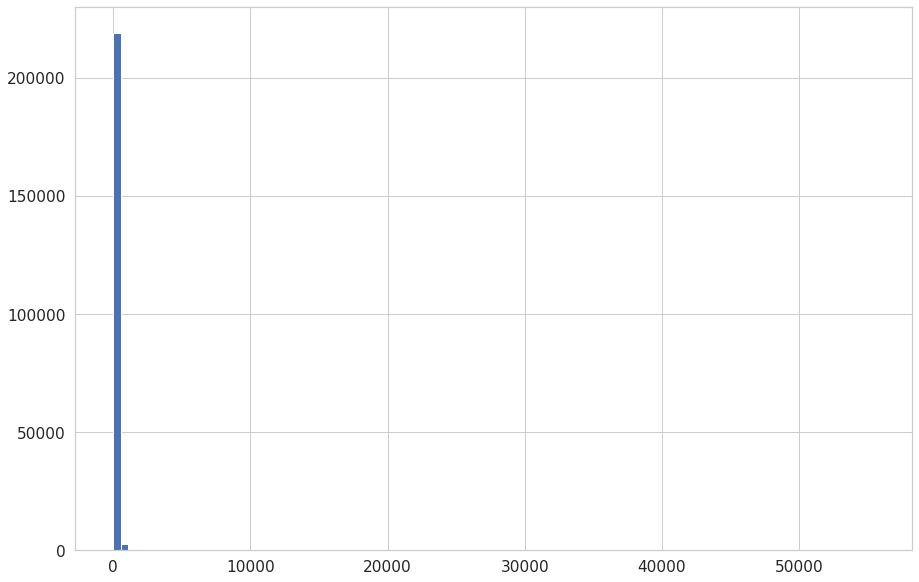

In [ ]:
df['len'].hist(bins=100, figsize=(15, 10))

In [ ]:
(df['len'] > 2000).sum()

170

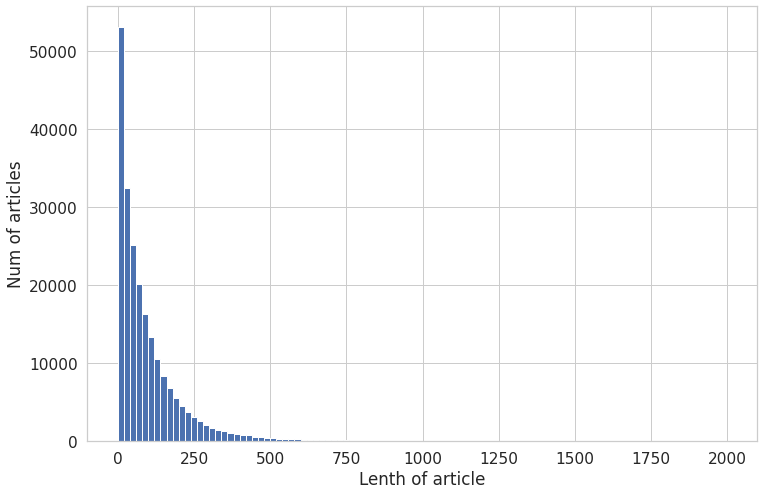

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(df[df['len'] < 2000]['len'], bins=100)
plt.xlabel('Lenth of article')
plt.ylabel('Num of articles');

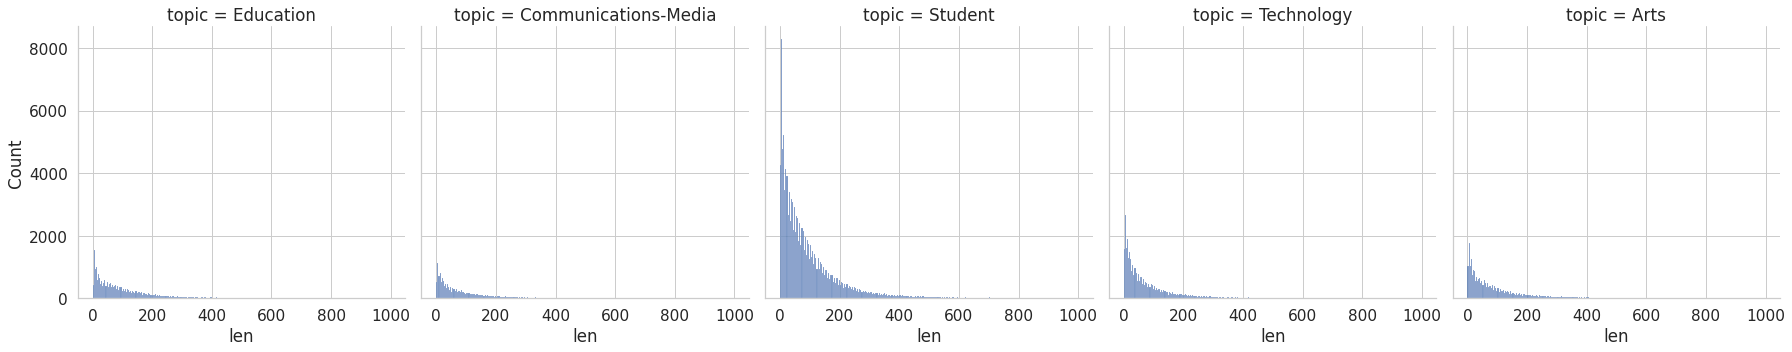

In [ ]:
sns.displot(df[df['len'] < 1000], x="len", col="topic", kind='hist')

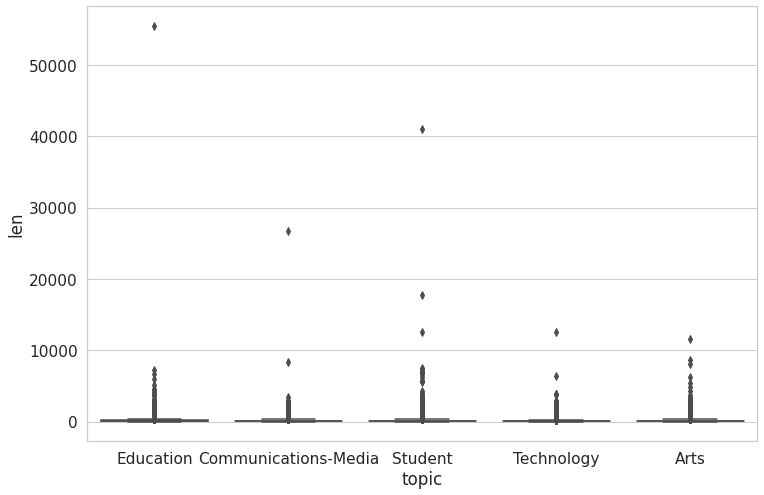

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="topic", y="len", data=df);

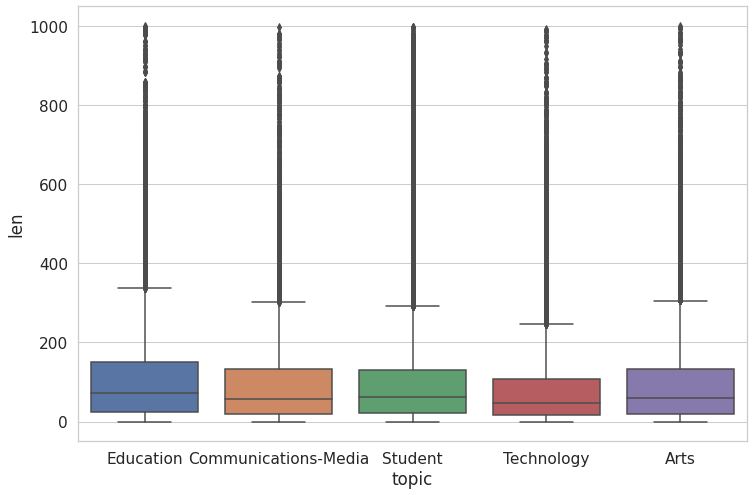

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="topic", y="len", data=df[df['len'] < 1000]);

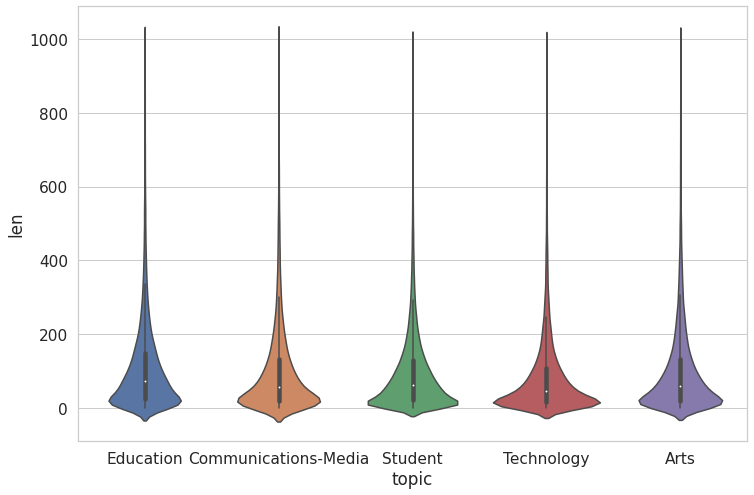

In [ ]:
plt.figure(figsize=(12, 8))
sns.violinplot(x="topic", y="len", data=df[df['len'] < 1000]);

In [ ]:
df.groupby('topic').agg(['mean', 'median', 'max', 'min'])

len                  
                            mean median    max min
topic                                             
Arts                  109.442505     60  11592   0
Communications-Media  110.520978     58  26687   0
Education             123.847218     72  55454   0
Student               103.675533     62  41033   0
Technology             88.595203     47  12624   0

Видим что длины статей очень сильно отличаются. С одной стороны много маленьких статей, в которых недостаточно смысла, чтобы понять, на какую тему пишет автор. С другой стороны большая часть текстов очень длинные, чтобы без урезания быть поданными модели, а при урезании может потеряться смысл, характерный для текстов на одну тематику. Кроме того средняя длина текстов очень близка, поэтому длину нельзя использовать как дополнительную информацию.

Кроме того, тематики очень близки (Education, Student, Technology), поэтому множества слов, харктерные топикам будут сильно пересекаться.

## Пересечение тематических словарей 

In [ ]:
word_sets = {label: set() for label in classes}

for text, label in tqdm(zip(train_dataset.data, train_dataset.labels)):
    word_sets[idx2label[label]] |= set(process_text(text))

In [ ]:
df_intersept = pd.DataFrame(index=classes, columns=classes)
df_intersept_ratio = pd.DataFrame(index=classes, columns=classes)

for a in classes:
    for b in classes:
      df_intersept.loc[a, b] = len(word_sets[a] & word_sets[b])
      df_intersept_ratio.loc[a, b] = round(len(word_sets[a] & word_sets[b]) / len(word_sets[a]), 2)
df_intersept

,Student,Technology,Arts,Education,Communications-Media
Student,250873,69796,67591,68334,57496
Technology,69796,110504,52129,52592,47111
Arts,67591,52129,99007,51392,46393
Education,68334,52592,51392,101317,46635
Communications-Media,57496,47111,46393,46635,77078


In [ ]:
print('Доля от словаря строки')
df_intersept_ratio

Доля от словаря строки


,Student,Technology,Arts,Education,Communications-Media
Student,1,0.28,0.27,0.27,0.23
Technology,0.63,1,0.47,0.48,0.43
Arts,0.68,0.53,1,0.52,0.47
Education,0.67,0.52,0.51,1,0.46
Communications-Media,0.75,0.61,0.6,0.61,1


## *Для токенов glove*

In [ ]:
word_sets = {label: set() for label in classes}

for text, label in tqdm(zip(train_dataset.tokenised, train_dataset.labels)):
    word_sets[idx2label[label]] |= set(text)

In [ ]:
df_intersept = pd.DataFrame(index=classes, columns=classes)
df_intersept_ratio = pd.DataFrame(index=classes, columns=classes)

for a in classes:
    for b in classes:
      df_intersept.loc[a, b] = len(word_sets[a] & word_sets[b])
      df_intersept_ratio.loc[a, b] = round(len(word_sets[a] & word_sets[b]) / len(word_sets[a]), 2)
df_intersept

,Student,Technology,Arts,Education,Communications-Media
Student,111819,57034,55349,56064,48718
Technology,57034,66224,44994,45615,41568
Arts,55349,44994,63532,44635,40793
Education,56064,45615,44635,65401,40983
Communications-Media,48718,41568,40793,40983,54144


In [ ]:
print('Доля от словаря строки')
df_intersept_ratio

Доля от словаря строки


,Student,Technology,Arts,Education,Communications-Media
Student,1,0.51,0.49,0.5,0.44
Technology,0.86,1,0.68,0.69,0.63
Arts,0.87,0.71,1,0.7,0.64
Education,0.86,0.7,0.68,1,0.63
Communications-Media,0.9,0.77,0.75,0.76,1


Предположение подтвердилось. Словарь Student пересекается со словарем любой другой тематики более чем на 80% от объема словаря. И чем меньше текстов по тематике было, те меньше уникальных слов в ее словаре. Что делает еще более сложным предсказание малых топиков.

## Обучение LSTM


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def pad_tensor(vec, length, dim, pad_symbol):
    pad_size = list(vec.shape)
    pad_size[dim] = length - vec.shape[dim]
    answer = torch.cat([vec, torch.ones(*pad_size, dtype=vec.dtype) * pad_symbol], axis=dim)
    return answer

def pad_tensors(tensors, dim=0, pad=0):
    # дополняет тензоры из tensors до общей максимальной длины символом pad
    if isinstance(tensors[0], (int, np.integer)):
        # массив целых чисел
        return torch.LongTensor(tensors)
    elif isinstance(tensors[0], (float, np.float)):
        # массив действительных чисел
        return torch.Tensor(tensors)
    if not isinstance(tensors[0], torch.Tensor):
        # приводим к массивам, чтобы можно было определить тип
        tensors = [np.array(tensor) for tensor in tensors]
        if np.issubdtype(tensors[0].dtype, np.integer):
            tensors = [torch.LongTensor(tensor) for tensor in tensors]
        else:
            tensors = [torch.Tensor(tensor) for tensor in tensors]
    L = max(tensor.shape[0] for tensor in tensors)
    tensors = [pad_tensor(tensor, L, dim=dim, pad_symbol=pad) for tensor in tensors]
    return torch.stack(tensors, dim=0)


class BatchDataLoader(DataLoader):

    def __init__(self, data, batch_size: int=32, pad=0, device="cpu", sort_field="input"):
        self.data = data
        self.batch_size = batch_size
        self.pad = pad
        self.device = device
        self.sort_field = sort_field

    def __iter__(self):
        self.order = np.argsort([len(elem[self.sort_field]) for elem in self.data])[::-1]
        self.idx = 0
        return self

    def __len__(self):
        return (len(self.data)-1) // self.batch_size + 1

    def __next__(self):
        if self.idx >= len(self.data):
            raise StopIteration()
        end = min(self.idx + self.batch_size, len(self.data))
        indexes = self.order[self.idx:end]
        # print(self.idx, end, indexes)
        answer = dict()
        for field in self.data[indexes[0]]:
            # записываем тензоры для всех полей
            answer[field] = pad_tensors([self.data[i][field] for i in indexes]).to(self.device)
        # записываем индексы всех объектов
        answer["indexes"] = indexes
        self.idx = end
        return answer

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, num_classes, embed_size, vocab_size, hidden_size=128, mean=False):
        super().__init__()
        self.mean = mean
        self.n_hidden = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.cls = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_outputs, states = self.lstm(x)
        state = states[0]
        if self.mean:
            state = torch.mean(lstm_outputs, dim=1)
        else:
            # state.shape = (B, 2, H)
            state = state.permute((1, 0, 2))
            # state.shape = (B, 2*H)
            state = state.reshape(-1, 2*self.n_hidden)

        output = self.cls(state)
        # print(hidden.shape)
        # output = self.ac(hidden)
        return output

In [ ]:
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support

In [ ]:
def freeze_embeddings(model, req_grad=False):
    embeddings = model.embedding
    for c_p in embeddings.parameters():
        c_p.requires_grad = req_grad

def measure_quality(y_test, y_pred, average='weighted'):
    accuracy = balanced_accuracy_score(y_test, y_pred)
    print(f'\t {average}')
    print("balanced accuracy: {:.2f}".format(accuracy))
    precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average=average)
    print("precision: {:.2f}".format(precision))
    print("recall: {:.2f}".format(recall))
    print("F1-score: {:.2f}".format(f_score))
    print()
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "F1": f_score}

In [ ]:
from tqdm.notebook import tqdm, trange

def training_freeze(model, criterion, optimizer, num_epochs, loaders, max_grad_norm=2, num_freeze_iter=1000):
    history = {
        'train_loss':[],
        'val_loss':[],
    }

    unfreeze_flg = False
    freeze_embeddings(model)
    for e in trange(num_epochs, leave=False):
        model.train()
        num_iter = 0
        
        train_loss = 0

        pbar = tqdm(loaders["train"], leave=False)
        for batch in pbar:

            if not unfreeze_flg and num_iter > num_freeze_iter:
                freeze_embeddings(model, True)
                unfreeze_flg = True
                
            optimizer.zero_grad()

            input_embeds = batch["input"].to(device)
            labels = batch["label"].to(device)

            prediction = model(input_embeds)
            loss = criterion(prediction, labels)
            train_loss += loss

            if num_iter % 1000 == 0:
                print('train loss: ', loss.item())
                print('train correct: ', (prediction.argmax(-1) == labels).float().sum().item())

            loss.backward()

            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            num_iter += 1
        
        history['train_loss'].append(train_loss / num_iter)

        valid_loss = 0
        val_labels = None
        val_predictions = None
        num_iter = 0
        model.eval()
        with torch.no_grad():
            correct = 0
            num_objs = 0
            for batch in loaders["test"]:
                input_embeds = batch["input"].to(device)
                labels = batch["label"].to(device)
                prediction = model(input_embeds)
            
                valid_loss += criterion(prediction, labels)
                
                if val_labels is None:
                    val_labels = labels
                else:
                    val_labels = torch.hstack([val_labels, labels])
                
                if val_predictions is None:
                    val_predictions = prediction.argmax(-1)
                else:
                    val_predictions = torch.hstack([val_predictions, prediction.argmax(-1)])

                num_objs += len(labels)
                num_iter += 1

            print('valid: ', (prediction.argmax(-1) == labels).float().sum().item())

            val_labels = val_labels.cpu().numpy()
            val_predictions = val_predictions.cpu().numpy()

        history['val_loss'].append(valid_loss / num_iter)

        measure_quality(val_labels, val_predictions, 'weighted')
        measure_quality(val_labels, val_predictions, 'macro')
        measure_quality(val_labels, val_predictions, 'micro')

        print(f"\n\tValid Loss: {valid_loss / num_iter}\n\t")

    return history

In [116]:
import torch
del model
torch.cuda.empty_cache()
import gc
gc.collect()

279038

In [117]:
idx2label

{0: 'Student',
 1: 'Education',
 2: 'Communications-Media',
 3: 'Arts',
 4: 'Technology'}

In [120]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = LSTMModel(len(label2idx), embed_size=glove_model.vector_size, vocab_size=len(glove_vocab.vocab)).to(device)

# bert
# model = LSTMModel(len(label2idx), embed_size=bert_embeddings.shape[1], vocab_size=bert_embeddings.shape[0]).to(device)
# bert

criterion = nn.CrossEntropyLoss(weight=torch.Tensor(1 / frequencies).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 4
max_grad_norm = 1.0

In [119]:
# bert
with torch.no_grad():
    model.embedding.weight = torch.nn.Parameter(torch.Tensor(bert_embeddings).to(device))

In [121]:
with torch.no_grad():
    for word, idx in glove_vocab.vocab.items():
        if word in glove_model:
            model.embedding.weight[idx] = torch.from_numpy(glove_model.get_vector(word))

In [122]:
loaders = {'train': BatchDataLoader(train_dataset, device="cuda:0", batch_size=30),
           'test': BatchDataLoader(test_dataset, device="cuda:0", batch_size=30)}

In [123]:
history = training_freeze(model, criterion, optimizer, num_epochs, loaders, max_grad_norm)

train loss:  1.6396572589874268
train correct:  5.0
train loss:  1.3141683340072632
train correct:  16.0
train loss:  1.5793540477752686
train correct:  13.0
train loss:  1.22262442111969
train correct:  18.0
train loss:  0.8161877989768982
train correct:  19.0
train loss:  1.2744624614715576
train correct:  17.0
train loss:  1.5951414108276367
train correct:  12.0
train loss:  1.353084921836853
train correct:  10.0
valid:  1.0
	 weighted
balanced accuracy: 0.27
precision: 0.71
recall: 0.27
F1-score: 0.24

	 macro
balanced accuracy: 0.27
precision: 0.59
recall: 0.27
F1-score: 0.18

	 micro
balanced accuracy: 0.27
precision: 0.27
recall: 0.27
F1-score: 0.27


	Valid Loss: 1.5597912073135376
	


train loss:  1.570476770401001
train correct:  7.0
train loss:  0.6271817088127136
train correct:  18.0
train loss:  1.5114586353302002
train correct:  19.0
train loss:  0.9411203861236572
train correct:  20.0
train loss:  0.34859922528266907
train correct:  27.0
train loss:  0.8072989583015442
train correct:  23.0
train loss:  1.56327223777771
train correct:  14.0
train loss:  1.1484990119934082
train correct:  13.0
valid:  3.0
	 weighted
balanced accuracy: 0.37
precision: 0.67
recall: 0.42
F1-score: 0.44

	 macro
balanced accuracy: 0.37
precision: 0.54
recall: 0.37
F1-score: 0.33

	 micro
balanced accuracy: 0.37
precision: 0.42
recall: 0.42
F1-score: 0.42


	Valid Loss: 1.4223119020462036
	


train loss:  0.9168081283569336
train correct:  17.0
train loss:  0.34151628613471985
train correct:  24.0
train loss:  1.1548500061035156
train correct:  23.0
train loss:  0.6957593560218811
train correct:  23.0
train loss:  0.17828093469142914
train correct:  27.0
train loss:  0.43337681889533997
train correct:  26.0
train loss:  1.3011895418167114
train correct:  15.0
train loss:  0.9625279307365417
train correct:  15.0
valid:  3.0
	 weighted
balanced accuracy: 0.40
precision: 0.64
recall: 0.46
F1-score: 0.48

	 macro
balanced accuracy: 0.40
precision: 0.49
recall: 0.40
F1-score: 0.37

	 micro
balanced accuracy: 0.40
precision: 0.46
recall: 0.46
F1-score: 0.46


	Valid Loss: 1.5257142782211304
	


train loss:  0.48643240332603455
train correct:  24.0
train loss:  0.1409243494272232
train correct:  27.0
train loss:  0.513054609298706
train correct:  25.0
train loss:  0.312534362077713
train correct:  28.0
train loss:  0.09073403477668762
train correct:  28.0
train loss:  0.21344320476055145
train correct:  28.0
train loss:  0.9240677952766418
train correct:  19.0
train loss:  0.8610783219337463
train correct:  17.0
valid:  3.0
	 weighted
balanced accuracy: 0.41
precision: 0.61
recall: 0.48
F1-score: 0.50

	 macro
balanced accuracy: 0.41
precision: 0.46
recall: 0.41
F1-score: 0.38

	 micro
balanced accuracy: 0.41
precision: 0.48
recall: 0.48
F1-score: 0.48


	Valid Loss: 1.732858657836914
	


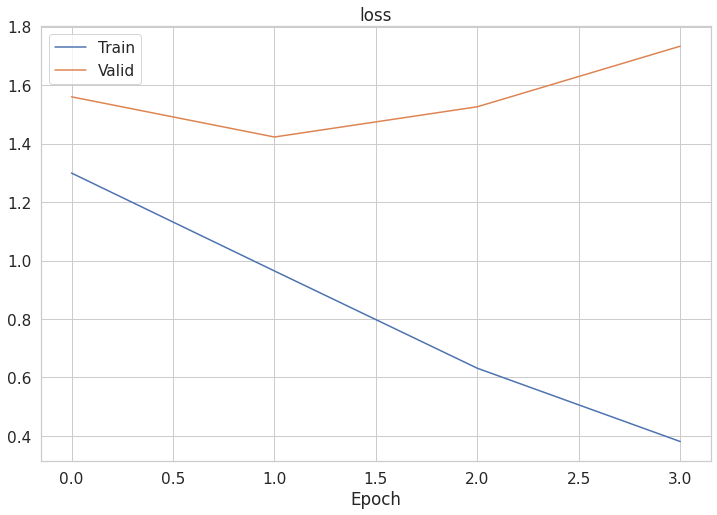

In [125]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(history['train_loss'])), history['train_loss'], label='Train')
plt.plot(np.arange(len(history['val_loss'])), history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.title('loss')
plt.legend()
plt.show()

Кусочек с обучением реккурентной сети из семинара. Запустили для того чтобы сравнить со своим кодом.

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, num_classes, embed_size, vocab_size, hidden_size=128, mean=False):
        super().__init__()
        self.mean = mean
        self.n_hidden = hidden_size
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.cls = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_outputs, states = self.lstm(x) #[:, -1, :]
        state = states[-1]
        if self.mean:
            state = torch.mean(lstm_outputs, dim=1)
        else:
            # state.shape = (B, 2, H)
            state = state.permute((1, 0, 2))
            # state.shape = (B, 2*H)
            state = state.reshape(-1, 2*self.n_hidden)

        output = self.cls(state)
        # print(hidden.shape)
        # output = self.ac(hidden)
        return output

    def train_on_batch(self, x, y):
        self.train()
        self.optimizer.zero_grad()
        loss = self._validate(x, y)
        loss["loss"].backward()
        self.optimizer.step()
        return loss

    def validate_on_batch(self, x, y):
        self.eval()
        with torch.no_grad():
            return self._validate(x, y)

    def _validate(self, x, y):
        if self.device is not None:
            y = y.to(self.device)
            x = x.to(self.device)
        prediction = self(x) #   self.forward(x) = self.__call__(x)
        loss = self.criterion(prediction, y)
        labels = prediction.argmax(-1)
        return {"loss": loss, "label": labels}

In [ ]:
def update_metrics(metrics, batch_output, batch_labels):
    n_batches = metrics["n_batches"]
    # Что здесь не так?
    metrics["loss"] = (metrics["loss"] * n_batches + batch_output["loss"].item()) / (n_batches + 1)
    metrics["n_batches"] += 1
    are_equal = (batch_output["label"] == batch_labels).cpu().numpy().astype("int")
    metrics["correct"] += are_equal.sum()
    metrics["total"] += are_equal.shape[0]
    metrics["accuracy"] = metrics["correct"] / max(metrics["total"], 1)

In [ ]:
def do_epoch(model, dataloader, mode="validate", epoch=1):
    metrics = {"correct": 0, "total": 0, "loss": 0.0, "n_batches": 1}

    func = model.train_on_batch if mode == "train" else model.validate_on_batch
    progress_bar = tqdm(dataloader, leave=True)
    progress_bar.set_description(f"{mode}, epoch={epoch}")

    for batch in progress_bar:
        batch_output = func(batch['input'], batch["label"])
        update_metrics(metrics, batch_output, batch["label"])
        progress_bar.set_postfix({"loss": round(metrics["loss"], 4), "acc": round(100 * metrics["accuracy"], 2)})
    return metrics

In [ ]:
train_dataloader = BatchDataLoader(train_dataset, device="cuda", batch_size=30)
test_dataloader = BatchDataLoader(test_dataset, device="cuda", batch_size=30)
NEPOCHS = 5

model = LSTMModel(len(label2idx), embed_size=glove_model.vector_size, vocab_size=len(glove_vocab.vocab)).to(device)

best_val_acc = 0.0
checkpoint = "checkpoint_best.pt"

for epoch in range(NEPOCHS):
    do_epoch(model, train_dataloader, mode="train", epoch=epoch+1)
    epoch_metrics = do_epoch(model, test_dataloader, mode="validate", epoch=epoch+1)

    if epoch_metrics["accuracy"] > best_val_acc:
        best_val_acc = epoch_metrics["accuracy"]
        print(f"Saving checkpoint after epoch {epoch+1}")
        torch.save(model.state_dict(), checkpoint)

model.load_state_dict(torch.load(checkpoint))
do_epoch(model, test_dataloader, mode="validate", epoch="evaluate")


Saving checkpoint after epoch 1


{'accuracy': 0.31128207723844714,
 'correct': 6150,
 'loss': 1.573903871666301,
 'n_batches': 660,
 'total': 19757}

In [ ]:
do_epoch(model, test_dataloader, mode="validate", epoch="evaluate")

In [ ]:
torch.argmax(torch.Tensor([[1, 2], [5, 4]]), axis=1)

tensor([1, 0])

# BERT

Запустить берт для классификации получилось - забирали с выхода 1 элемент (cls) и передавали в лог регрессию. Однако обучить на большом числе данных (даже 1000 текстах) не получилось из-за ограничений колаба по памяти. Так что брали от берта только эмбендинги слов - это было выше.

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 9.1MB/s 
     |████████████████████████████████| 3.3MB 33.7MB/s 
     |████████████████████████████████| 901kB 50.0MB/s 


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
blade = 500

In [ ]:
text_data = data['text'][:blade]

In [ ]:
topics = data['topic'][:blade]

In [ ]:
labels = []
for topic in topics:
    labels.append(label2idx[topic])

In [ ]:
len(labels)

250

In [ ]:
max_len = 500
for text in tqdm(text_data.index):
    if len(text_data[text]) > max_len:
        text_data[text] = text_data[text][:max_len]

### Tokenization

In [ ]:
tokenized = text_data[:blade].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
tokenized

0      [101, 18558, 2038, 2042, 2179, 1006, 1009, 101...
1      [101, 2122, 2024, 1996, 2136, 2372, 1024, 3881...
2      [101, 1999, 21770, 26159, 2099, 3158, 22762, 2...
3      [101, 5604, 999, 999, 999, 5604, 999, 999, 999...
4      [101, 8299, 1024, 1013, 1013, 7479, 1012, 2039...
                             ...                        
245    [101, 2061, 1996, 3976, 2005, 1996, 2166, 1997...
246    [101, 2253, 2197, 2305, 2000, 1996, 7090, 6765...
247    [101, 2242, 8572, 2015, 2033, 2055, 1996, 2403...
248    [101, 4033, 1005, 1056, 6866, 2505, 1999, 1037...
249    [101, 2619, 3531, 4863, 2000, 2033, 2129, 2619...
Name: text, Length: 250, dtype: object

### Padding

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

### Masking

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(250, 178)

### Model

In [ ]:
input_ids = torch.tensor(np.array(padded))

with torch.no_grad():
    last_hidden_states = model(input_ids)

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()
labels = labels[:blade]

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr_clf.score(test_features, test_labels)

0.6984126984126984

In [ ]:
# равномерно 100 samples - 0.6, 0.76, 0,68
# равномерно250 samples - 0.6984